<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.
Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

Control: gate_30

Trataimiento: gate_40

test para 1 día

test para 7 días

In [88]:
import pandas as pd
import numpy as np

from bayes import *
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import bernoulli, beta  
from scipy.stats import norm, sem
import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt

In [89]:
df = pd.read_csv('data/cookie_cats.csv')

df.columns = [i.lower().replace(' ','_') for i in df.columns]

In [90]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Bayes retention_1

In [91]:
imps_ctrl = 44700
convs_ctrl = len(df[(df.version == 'gate_30') & (df.retention_1 == True)])

imps_test = 45489
convs_test = (len(df[(df.version == 'gate_40') & (df.retention_1 == True)]))

In [92]:
CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas estancia: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas estancia: Control: 0.4481879194630872, Test: 0.44228274967574577'

In [93]:
# A prioris
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/var/folders/h7/xhgpgb3d0s55331krx9jbrv80000gn/T/ipykernel_2262/1756304866.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))


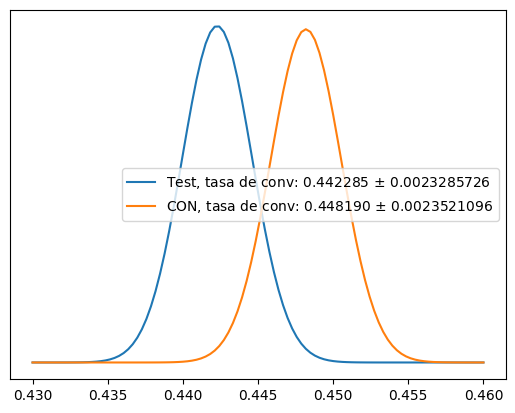

In [94]:
x=np.linspace(0.43, 0.46, 100)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();
plot([beta_test, beta_control], ['Test', 'CON'])


In [95]:
salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()
print('diferencia normalizada de las medias de test y control: ',salto)

diferencia normalizada de las medias de test y control:  0.013175098158249857


In [96]:
prob = beta_test.cdf(0.445)

'''El test reduce la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test reduce la tasa de conversion en un 1.32%, con una probabilidad del 87.81%'

# Bayes retention_7

In [97]:
imps_ctrl = 44700
convs_ctrl = len(df[(df.version == 'gate_30') & (df.retention_7 == True)])

imps_test = 45489
convs_test = (len(df[(df.version == 'gate_40') & (df.retention_7 == True)]))

In [98]:
CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas estancia: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas estancia: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [99]:
# A prioris
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test


beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/var/folders/h7/xhgpgb3d0s55331krx9jbrv80000gn/T/ipykernel_2262/2923873394.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))


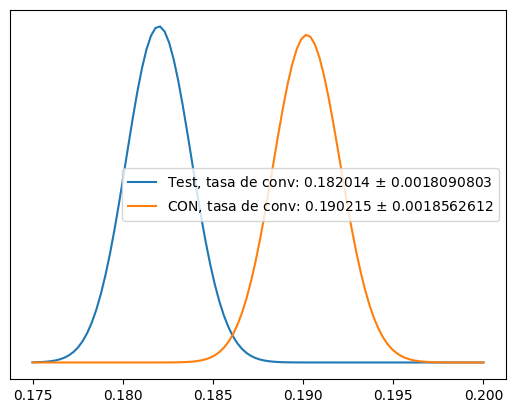

In [100]:
x=np.linspace(0.175, 0.20, 100)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();
plot([beta_test, beta_control], ['Test', 'CON'])

In [101]:
salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()
print('diferencia normalizada de las medias de test y control: ',salto)

diferencia normalizada de las medias de test y control:  0.04311526114658881


In [102]:
prob = beta_test.cdf(0.18625)

'''El test reduce la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test reduce la tasa de conversion en un 4.31%, con una probabilidad del 99.01%'